# Dataframe HowTo with UK-DALE - Daily Analysis

Series and DataFrame objects in pandas are very powerful tools for exploring and analyzing data. Part of their power comes from a multifaceted approach to combining separate datasets, and also performing query for the filter data.

This ipynb is aim to support "daily" UK-DALE analysis, it targets to break down into day, minute(s) or second(s).

**Reference:**
- [Pandas Documentation 0.25.3](https://pandas.pydata.org/pandas-docs/version/0.25.3/getting_started/comparison/comparison_with_sql.html)
- [Pandas Query w3schools](https://www.w3schools.com/python/pandas/ref_df_query.asp)
- [Concatnate Pandas Series](https://www.w3resource.com/pandas/series/series-append.php)
- [Dealing with DateTime Index with Pandas](https://www.sergilehkyi.com/tips-on-working-with-datetime-index-in-pandas/)
        

In [1]:
import dateutil
import warnings

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

from datetime import datetime

import nilmtk as ntk
import utility as ut

print("Pandas version: {}".format(pd.__version__))

Pandas version: 0.25.3


In [2]:
plt.rcParams['figure.figsize'] = [15, 10]
RAW_FILENAME = "../../../ukdale/ukdale.h5"

START_TS ='2013-08-01 00:00:00'
END_TS   ='2013-08-01 23:59:59'

STR_TITLE_TS = START_TS + " To " + END_TS

HOUSE_NUMBER = 1

# Create object for ukdale
train_ds = ntk.DataSet(RAW_FILENAME)
train_ds.set_window(start=START_TS,end=END_TS)

# Create object for house_data and
# using global variable "HOUSE_NUMBER"
train_house_data = train_ds.buildings[HOUSE_NUMBER].elec

# Mains and Top 5 Appliances

This is to breakdown individual analysis to perform data summary with generating two materialized dataframes.

## Mains - mains_df

### Get mains and load to dataframe - mains_df 

In [3]:
mains = train_house_data.mains()
raw_df_mains = next(mains.load(sample_period=6))

raw_df_mains.shape

(14400, 3)

In [4]:
raw_df_mains.columns

MultiIndex([(  'power',   'active'),
            (  'power', 'apparent'),
            ('voltage',         '')],
           names=['physical_quantity', 'type'])

In [5]:
raw_df_mains.head()

physical_quantity                power                  voltage
type                            active     apparent            
2013-08-01 00:00:00+01:00  2516.064941  2528.441650  241.766663
2013-08-01 00:00:06+01:00  2536.000000  2549.078369  242.688339
2013-08-01 00:00:12+01:00  2532.243408  2545.000000  242.581665
2013-08-01 00:00:18+01:00  2532.551758  2545.389893  242.520004
2013-08-01 00:00:24+01:00  2530.321777  2543.165039  242.471664

### Flatten Multi-Index columns header and change header name - view_df_main

In [6]:
view_df_mains = raw_df_mains.copy()

view_df_mains.columns = ["_".join(pair) for pair in view_df_mains.columns]

#view_df_main

# change column name 
view_df_mains = view_df_mains.rename(columns={"power_active":"m_active"})
view_df_mains = view_df_mains.rename(columns={"voltage_":"m_voltage"})
view_df_mains = view_df_mains.rename(columns={"power_apparent":"m_apparent"})

view_df_mains.describe()

,m_active,m_apparent,m_voltage
count,14400.000000,14400.000000,14400.000000
mean,368.388702,426.475494,242.394485
std,456.214478,462.680847,1.323650
min,93.661667,143.396667,236.326660
25%,184.130417,215.222496,241.516663
50%,271.643326,323.292496,242.559998
75%,373.017082,419.359169,243.410004
max,3000.571777,3053.013428,246.661667


### Analysis mains Hourly with Boxplot

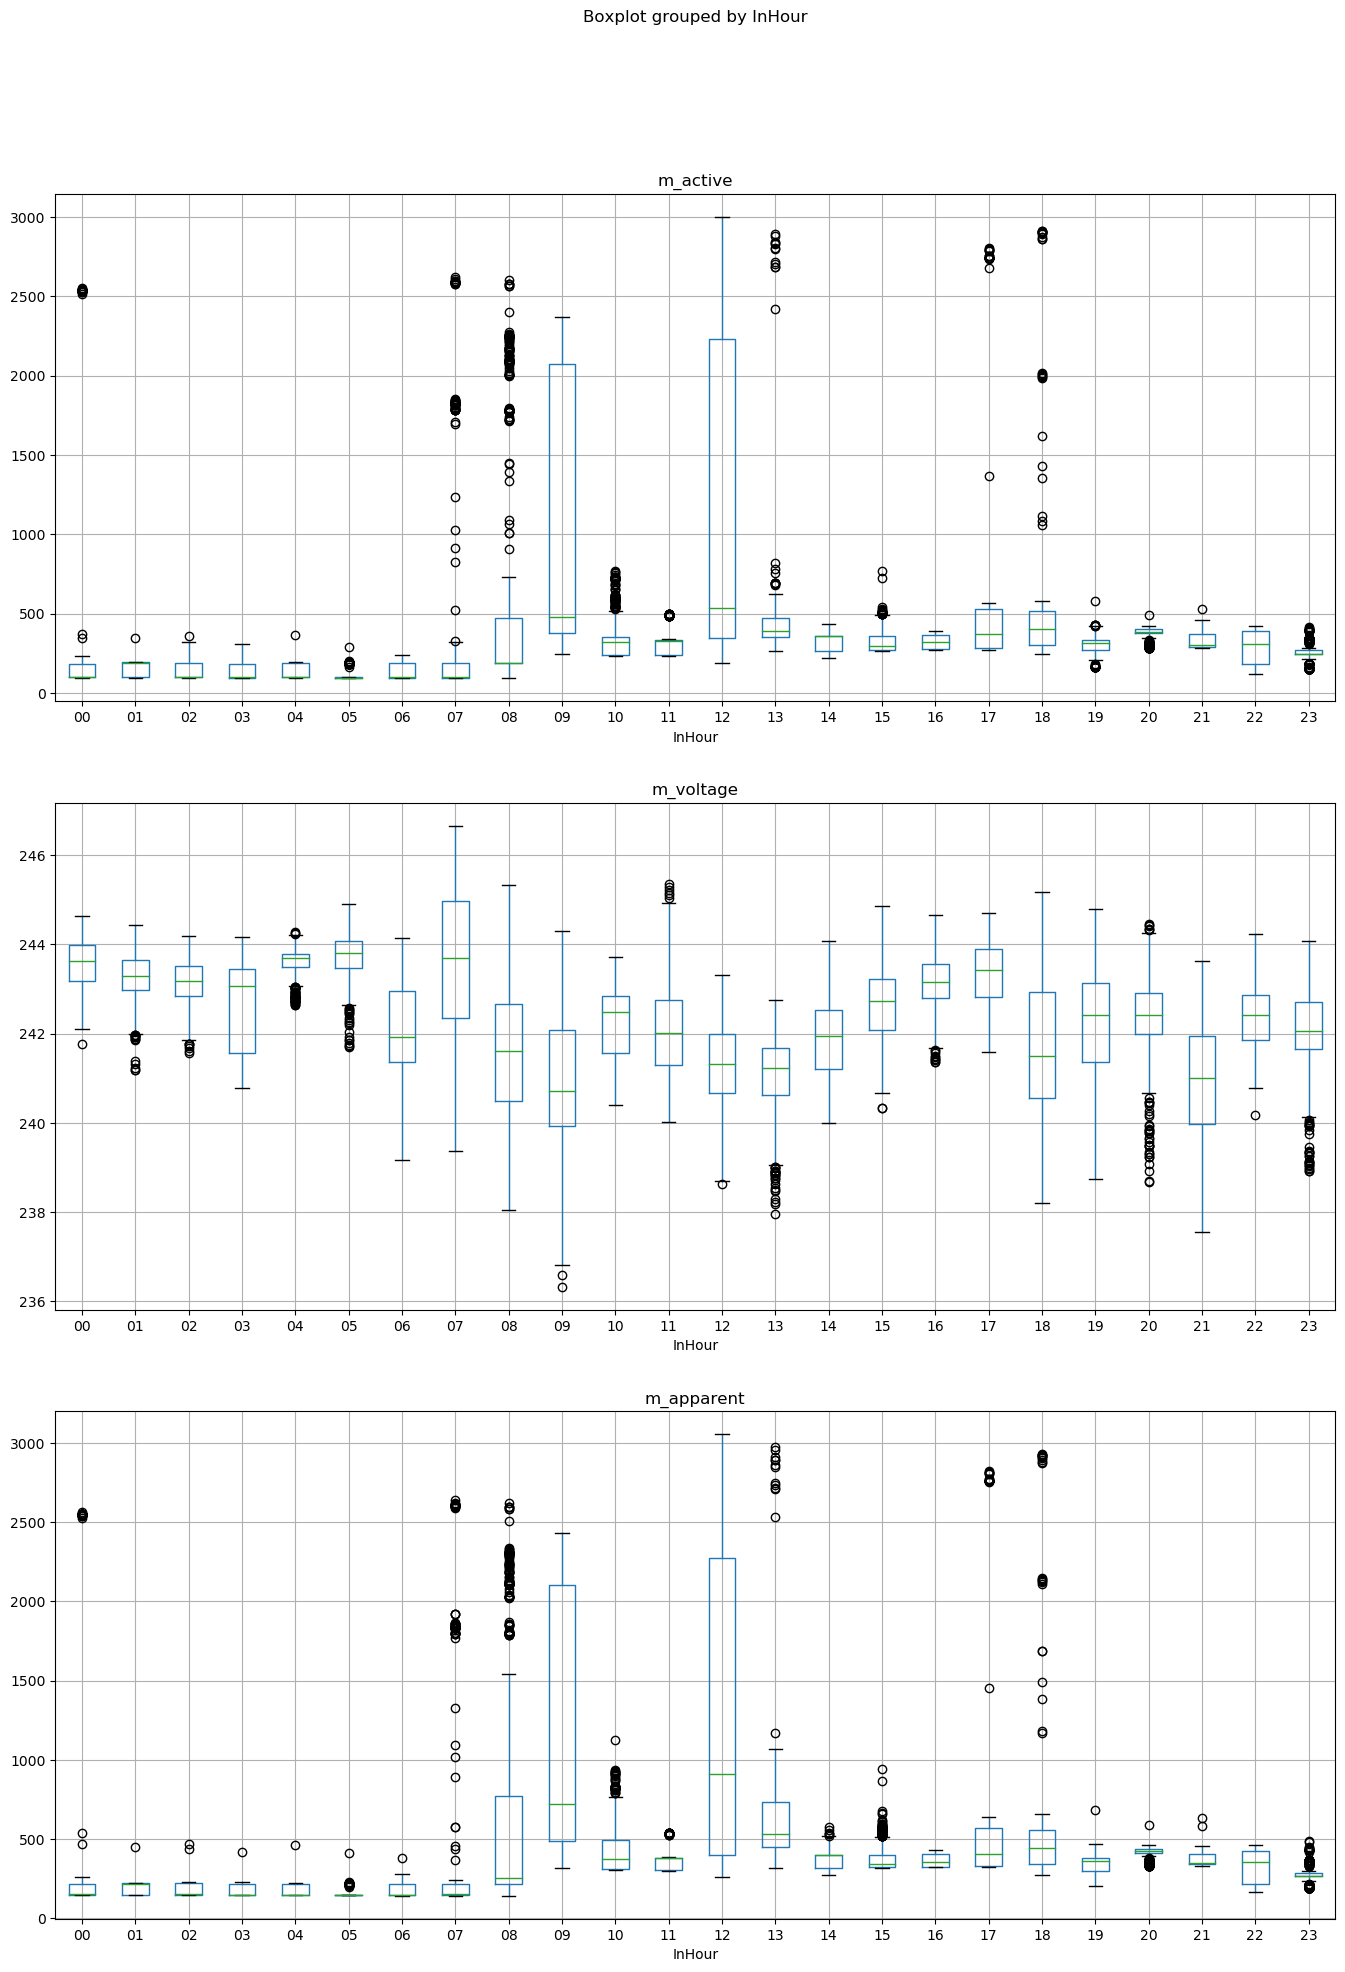

In [7]:
fig, axes = plt.subplots(nrows=3, ncols=1, figsize=(16, 23))

plot_df_bp = view_df_mains.copy()

plot_df_bp['InHour'] = plot_df_bp.index.strftime('%H')
plot_df_bp = plot_df_bp.set_index('InHour')

plot_df_bp.boxplot(by='InHour', column=['m_active'], ax = axes[0])
plot_df_bp.boxplot(by='InHour', column=['m_voltage'], ax = axes[1])
plot_df_bp.boxplot(by='InHour', column=['m_apparent'], ax = axes[2])

### Resample to Minute & Plot

array([<matplotlib.axes._subplots.AxesSubplot object at 0x000001D03DBB4E20>,
      dtype=object)

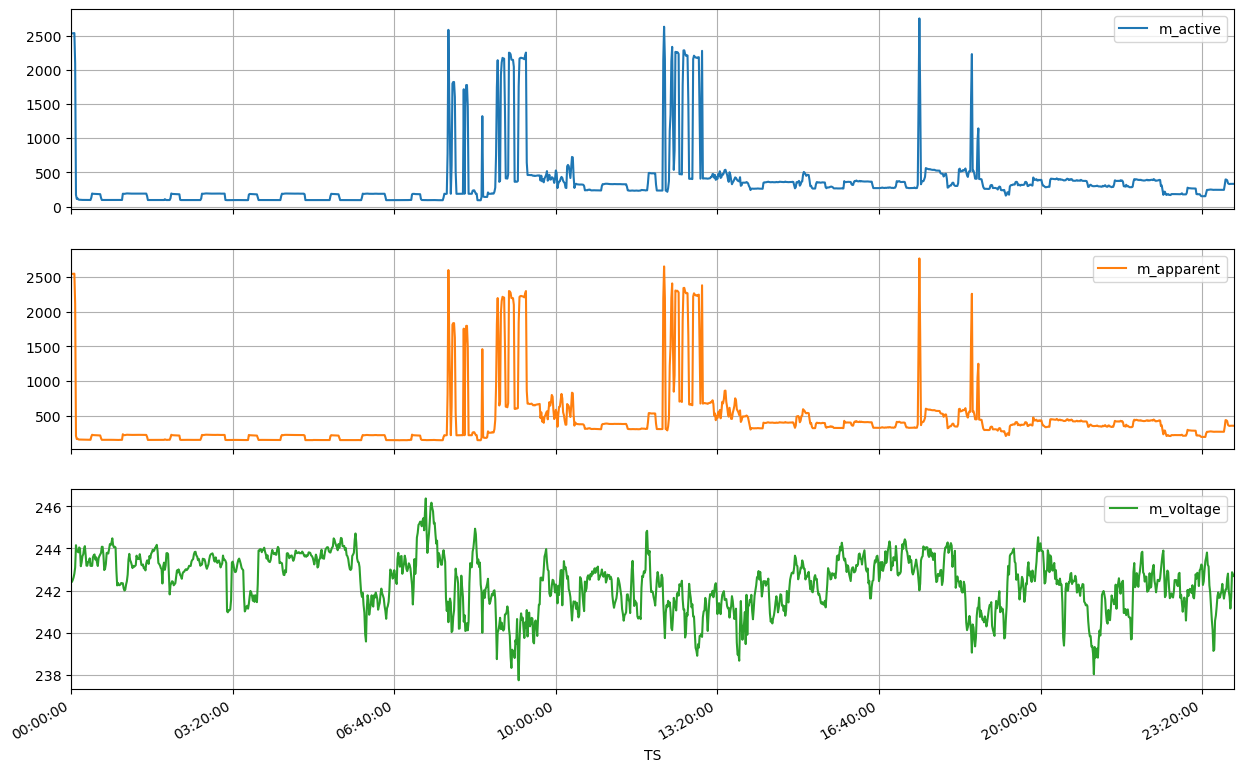

In [8]:
# Duplicate dataframe for plotting
plot_df_resample = view_df_mains.resample('1min').mean()

# Handling xtickslabel datetime format
plot_df_resample["TS"] = plot_df_resample.index.strftime('%H:%M:%S')
plot_df_resample = plot_df_resample.set_index('TS')

plot_df_resample.plot(subplots=True, x_compat=True, grid=True)

In [9]:
plot_df_resample.describe(include = 'all')

,m_active,m_apparent,m_voltage
count,1440.000000,1440.000000,1440.000000
mean,368.388702,426.475525,242.394485
std,435.450226,441.548401,1.291552
min,94.043671,143.967331,237.741165
25%,183.981586,215.460625,241.514835
50%,273.734589,324.445419,242.554855
75%,377.658745,425.367920,243.379089
max,2752.456787,2769.834229,246.377838


### Check whether any null values in columns

In [10]:
cnt = 0
for column in view_df_mains:
    cnt_null = view_df_mains[column].isnull().sum()
    if cnt_null > 0:
        print("{} has {} null row(s).".format(column, cnt_null))
        cnt=+1

if cnt == 0:
    print("Hurray! No null value found in mains_df.")

Hurray! No null value found in mains_df.


## Top 5 Appliances

### Get Top 5 appliances and load to dataframe - top_5_appliances_df

In [11]:
## Select Top-5 Appliances
top_5_house_data = train_house_data.submeters().select_top_k(k=5)

print("\n\nData Type of mg_top is {}.".format(type(top_5_house_data))) 

# Show the selected MeterGroup values
top_5_house_data

52/52 ElecMeter(instance=53, building=1, dataset='UK-DALE', appliances=[Appliance(type='printer', instance=1)])ance=1)])e(type='external hard disk', instance=1)])e=2), Appliance(type='radio', instance=3)])1)])

Data Type of mg_top is <class 'nilmtk.metergroup.MeterGroup'>.


MeterGroup(meters=
  ElecMeter(instance=5, building=1, dataset='UK-DALE', appliances=[Appliance(type='washer dryer', instance=1), Appliance(type='washer dryer', instance=2)])
  ElecMeter(instance=12, building=1, dataset='UK-DALE', appliances=[Appliance(type='fridge freezer', instance=1)])
  ElecMeter(instance=3, building=1, dataset='UK-DALE', appliances=[Appliance(type='solar thermal pumping station', instance=1)])
  ElecMeter(instance=10, building=1, dataset='UK-DALE', appliances=[Appliance(type='kettle', instance=1), Appliance(type='food processor', instance=1), Appliance(type='toasted sandwich maker', instance=1)])
  ElecMeter(instance=7, building=1, dataset='UK-DALE', appliances=[Appliance(type='television', instance=1)])
)

In [12]:
# Load data to dataframe from MeterGroup
raw_df_appliances_top5 = top_5_house_data.dataframe_of_meters()

print("Is there any null value in dataframe = {}.\n".format(raw_df_appliances_top5.isnull().values.any()))

# Change readable column name
raw_df_appliances_top5.columns = train_house_data.get_labels(raw_df_appliances_top5.columns)

# Show dataframe info for MeterGroup
raw_df_appliances_top5.describe()

Is there any null value in dataframe = True.



C:\Users\chaut\Anaconda3\envs\nilmtk-env\lib\site-packages\nilmtk\elecmeter.py:188: RuntimeWarning: Multiple appliances are associated with meter {} but none are marked as the dominant appliance. Hence returning the first appliance in the list.
  warn('Multiple appliances are associated with meter {}'


,Washer dryer,Fridge freezer,Solar thermal pumping station,Kettle,Television
count,14400.000000,14400.000000,14400.000000,14399.000000,14400.000000
mean,75.643158,48.327641,20.027256,17.208765,16.075659
std,332.604462,49.662983,23.816330,192.385269,35.963825
min,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,0.000000,0.000000,1.000000,1.000000
50%,0.000000,81.000000,0.000000,1.000000,1.000000
75%,0.000000,93.000000,47.000000,1.000000,1.000000
max,3640.000000,504.000000,52.000000,2393.000000,148.000000


In [13]:
raw_df_appliances_top5.shape

(14400, 5)

In [14]:
totcolrow = raw_df_appliances_top5.shape
print("There are totla of {} columns and {} rows in the top5 dataframe.".format(totcolrow[1], totcolrow[0]))

for column in raw_df_appliances_top5:
    cnt_null = raw_df_appliances_top5[column].isnull().sum()
    if cnt_null > 0:
        print("{} has {} null row(s).".format(column, cnt_null))

There are totla of 5 columns and 14400 rows in the top5 dataframe.
Kettle has 1 null row(s).


### Check whether any missing data and Fix

In [15]:
raw_df_appliances_top5[raw_df_appliances_top5.isnull().any(axis=1)]

,Washer dryer,Fridge freezer,Solar thermal pumping station,Kettle,Television
2013-08-01 23:59:54+01:00,0.0,92.0,0.0,NaN,1.0


In [16]:
# Duplicate raw top5 appliance dataframe to new fix
top5_fix_df = raw_df_appliances_top5.copy()

# Fix by replacing null to zero
top5_fix_df['Kettle'] = top5_fix_df['Kettle'].fillna(0)

### Plot Top 5 Appliances

array([<matplotlib.axes._subplots.AxesSubplot object at 0x000001D03FE94490>,
      dtype=object)

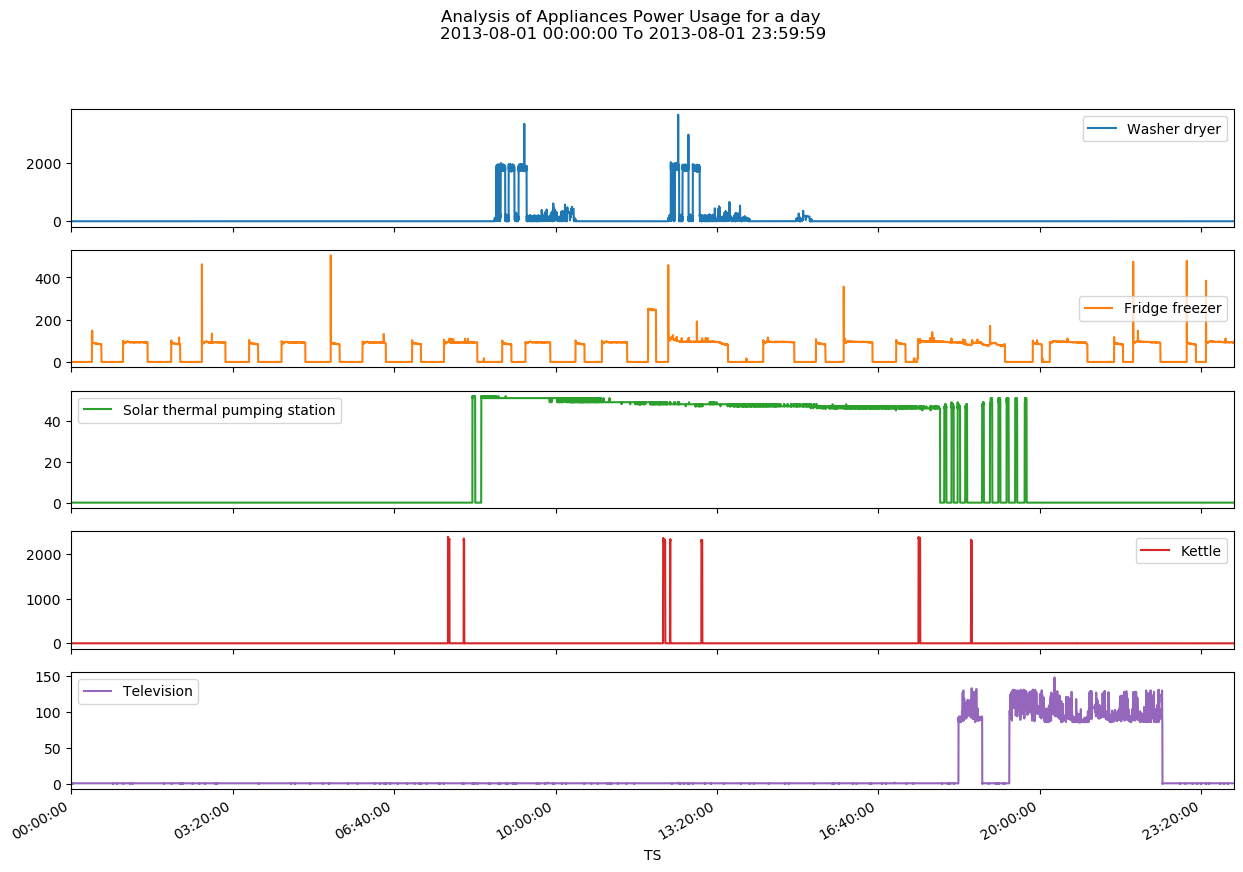

In [17]:
# Make a copy of dataframe and materialize for plotting

plot_top5_df = top5_fix_df.copy()

plot_top5_df["TS"] = plot_top5_df.index.strftime('%H:%M:%S')

plot_top5_df = plot_top5_df.set_index('TS')

mytitle = "Analysis of Appliances Power Usage for a day \n" + STR_TITLE_TS
plot_top5_df.plot(title=mytitle, subplots=True)

## Initial Data Analysis Mains and Top 5 Appliances - top5_summary_df

### Summarize top5_appliances_df

In [18]:
# Initialize a dataframe to store summary
top5_summary_df = pd.DataFrame(columns=['Name', 'MIN', 'AVG', 'MAX', 'SUM'])

# Get values row by row for top 5 appliances
for column in top5_fix_df:
    tmprow = {'Name' : column, 
              'MIN' : top5_fix_df[column].min(), 
              'AVG' : top5_fix_df[column].mean(),
              'MAX' : top5_fix_df[column].max(),
              'SUM' : top5_fix_df[column].sum()
             }
    
    top5_summary_df = top5_summary_df.append(tmprow, ignore_index=True)

 # Show all data   
top5_summary_df.head((top5_summary_df.shape)[0])

,Name,MIN,AVG,MAX,SUM
0,Washer dryer,0.0,75.643158,3640.0,1089261.5
1,Fridge freezer,0.0,48.327641,504.0,695918.0
2,Solar thermal pumping station,0.0,20.027256,52.0,288392.5
3,Kettle,0.0,17.207569,2393.0,247789.0
4,Television,0.0,16.075659,148.0,231489.5


### Summarize  view_df_mains

In [19]:
for column in view_df_mains:
    tmprow = {'Name' : column, 
              'MIN' : view_df_mains[column].min(), 
              'AVG' : view_df_mains[column].mean(),
              'MAX' : view_df_mains[column].max(),
              'SUM' : view_df_mains[column].sum()
             }
    top5_summary_df = top5_summary_df.append(tmprow, ignore_index=True)

 # Show all data   
top5_summary_df.head((top5_summary_df.shape)[0])

,Name,MIN,AVG,MAX,SUM
0,Washer dryer,0.000000,75.643158,3640.000000,1089261.5
1,Fridge freezer,0.000000,48.327641,504.000000,695918.0
2,Solar thermal pumping station,0.000000,20.027256,52.000000,288392.5
3,Kettle,0.000000,17.207569,2393.000000,247789.0
4,Television,0.000000,16.075659,148.000000,231489.5
5,m_active,93.661667,368.388702,3000.571777,5304797.5
6,m_apparent,143.396667,426.475494,3053.013428,6141247.0
7,m_voltage,236.326660,242.394485,246.661667,3490480.5


### Findings

Found out that the max value of Washer dryer is 3640, and apparent of mains os 3053.  This is abnormal, as mains max value should be higher than all appliances's max value.

Further investigation is needed to find out the particular records.

### Study record on appliance 2013-08-01 12:21:54+01:00

In [21]:
# Filter Washer dryer max value
ret_max_rec_app_df = top5_fix_df.query("`Washer dryer` >= 3640")

ret_max_rec_app_df

C:\Users\chaut\Anaconda3\envs\nilmtk-env\lib\site-packages\pandas\core\generic.py:456: FutureWarning: The default of the 'keep_tz' keyword in DatetimeIndex.to_series will change to True in a future release. You can set 'keep_tz=True' to obtain the future behaviour and silence this warning.
  s = level_values.to_series()
C:\Users\chaut\Anaconda3\envs\nilmtk-env\lib\site-packages\pandas\core\generic.py:464: FutureWarning: The default of the 'keep_tz' keyword in DatetimeIndex.to_series will change to True in a future release. You can set 'keep_tz=True' to obtain the future behaviour and silence this warning.
  dindex = axis_index.to_series()


,Washer dryer,Fridge freezer,Solar thermal pumping station,Kettle,Television
2013-08-01 12:31:54+01:00,3640.0,99.0,49.0,1.0,1.0


In [23]:
# Appliance record on 2013-08-01 12:21:54+01:00
top5_fix_df.loc['2013-08-01 12:21:54+01:00']

Washer dryer                      110.0
Fridge freezer                    106.0
Solar thermal pumping station      48.0
Kettle                           2324.0
Television                          1.0
Name: 2013-08-01 12:21:54+01:00, dtype: float32

### Study record on mains 2013-08-01 12:21:54+01:00

In [24]:
ret_max_rec_m_df = view_df_mains.query("`m_apparent` >= 3053")
ret_max_rec_m_df

,m_active,m_apparent,m_voltage
2013-08-01 12:21:54+01:00,3000.571777,3053.013428,240.848328


In [25]:
# Appliance record on 2013-08-01 12:21:54+01:00
view_df_mains.loc['2013-08-01 12:31:54+01:00']

m_active      2207.548340
m_apparent    2230.708252
m_voltage      242.301666
Name: 2013-08-01 12:31:54+01:00, dtype: float32

# Merging Dataframe 

This is to merge both dataframe of mains and top5_appliances, it named 'merge_df'.  Then, it follows with comparison analysis.

## Validate two index columns 

In [27]:
# Duplicate dataframe
tmpdf_mains = view_df_mains.copy()
tmpdf_top5 = top5_fix_df.copy()

index_list_mains = list(tmpdf_mains.index.values)
index_list_top5 = list(tmpdf_top5.index.values)

if(index_list_mains==index_list_top5):
  print("Equal")
else:
  print("Non equal")

Equal


## Merge two dataframe - merge_df

In [28]:
# Create a new column and sum of all appliance
tmpdf_top5['TotApp'] =  tmpdf_top5.sum(axis=1)

merge_df = tmpdf_mains.join(tmpdf_top5)

merge_df.shape

(14400, 9)

In [29]:
merge_df

,m_active,m_apparent,m_voltage,Washer dryer,Fridge freezer,Solar thermal pumping station,Kettle,Television,TotApp
2013-08-01 00:00:00+01:00,2516.064941,2528.441650,241.766663,0.0,0.0,0.0,1.0,1.0,2.0
2013-08-01 00:00:06+01:00,2536.000000,2549.078369,242.688339,0.0,0.0,0.0,1.0,1.0,2.0
2013-08-01 00:00:12+01:00,2532.243408,2545.000000,242.581665,0.0,0.0,0.0,1.0,1.0,2.0
2013-08-01 00:00:18+01:00,2532.551758,2545.389893,242.520004,0.0,0.0,0.0,1.0,1.0,2.0
2013-08-01 00:00:24+01:00,2530.321777,2543.165039,242.471664,0.0,0.0,0.0,1.0,1.0,2.0
...,...,...,...,...,...,...,...,...,...
2013-08-01 23:59:30+01:00,334.303345,353.728333,242.925003,0.0,93.0,0.0,1.0,1.0,95.0
2013-08-01 23:59:36+01:00,333.676666,353.190002,242.574997,0.0,92.0,0.0,1.0,1.0,94.0
2013-08-01 23:59:42+01:00,334.315002,353.641663,242.676666,0.0,92.0,0.0,1.0,1.0,94.0
2013-08-01 23:59:48+01:00,333.643341,352.916656,242.551666,0.0,92.0,0.0,1.0,1.0,94.0


## Plot the overview of merge_df with custom columns

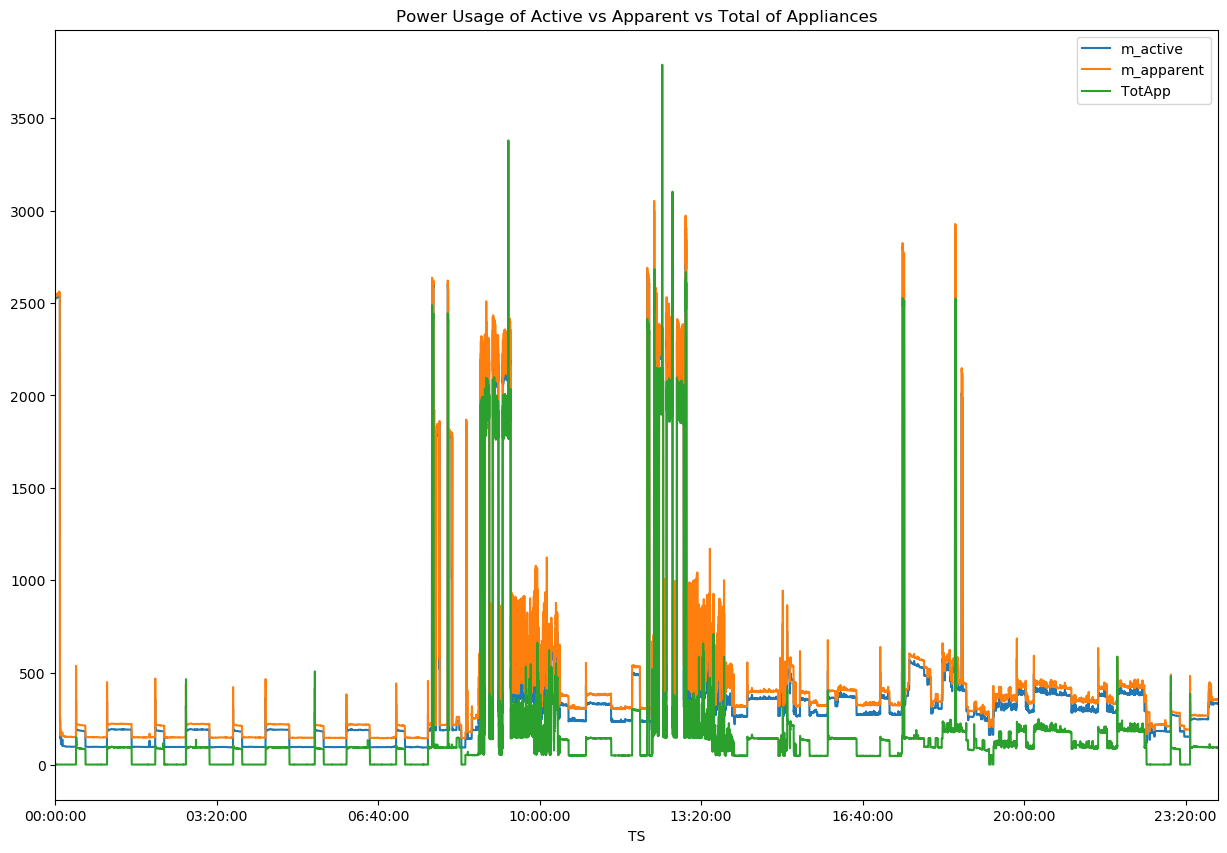

In [30]:
tmpplot_df = merge_df.copy()
tmpplot_df["TS"] = tmpplot_df.index.strftime('%H:%M:%S')
tmpplot_df = tmpplot_df.set_index('TS')

tmpplot_df.plot(title="Power Usage of Active vs Apparent vs Total of Appliances",
              y=["m_active", "m_apparent", "TotApp"])

## Total up the columns of datafame

In [31]:
sumtot_sr = tmpplot_df.select_dtypes(pd.np.number).sum()

# Return in Series data type
sumtot_sr

m_active                         5304798.5
m_apparent                       6141237.0
m_voltage                        3490474.5
Washer dryer                     1089261.5
Fridge freezer                    695918.0
Solar thermal pumping station     288392.5
Kettle                            247789.0
Television                        231489.5
TotApp                           2552850.5
dtype: float32

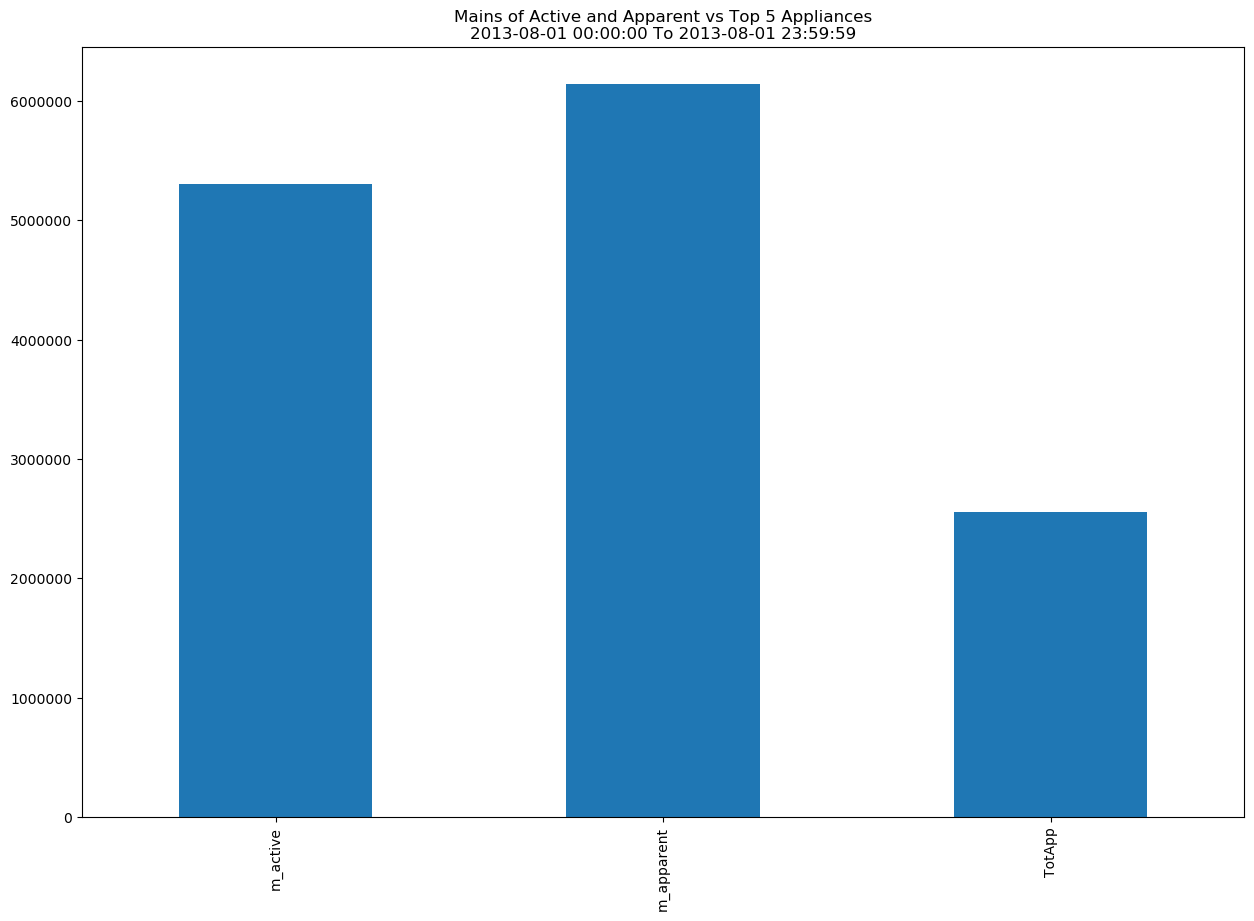

In [32]:
mytitle = "Mains of Active and Apparent vs Top 5 Appliances\n" + STR_TITLE_TS

sumtot_sr[['m_active', 'm_apparent', 'TotApp']].plot(kind='bar',
                                                     title=mytitle)

## Ratio of Top 5 Appliances with Others

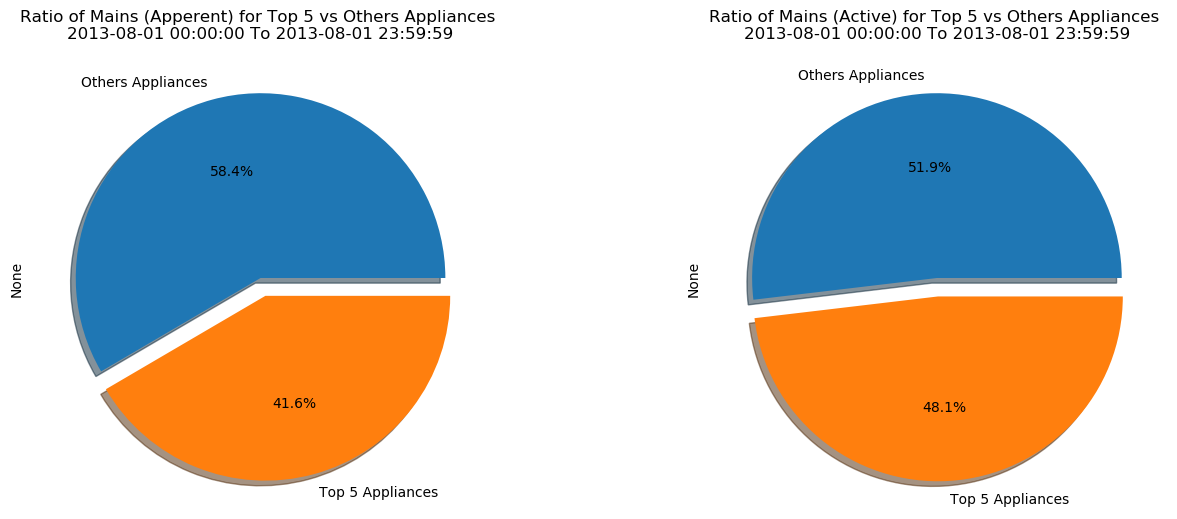

In [33]:
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(16, 6))

sumtot_sr['TotOtherAppWithApperent'] = sumtot_sr['m_apparent'] - sumtot_sr['TotApp']

mytitle = "Ratio of Mains (Apperent) for Top 5 vs Others Appliances \n" + STR_TITLE_TS
mylabel = ['Others Appliances', 'Top 5 Appliances']

sumtot_sr[['TotOtherAppWithApperent', 'TotApp']].plot(kind='pie',
                                                      labels=mylabel, 
                                                      autopct='%1.1f%%',
                                                      explode=[0,0.1],
                                                      shadow=True,
                                                      title=mytitle,
                                                      ax = axes[0])

mytitle = "Ratio of Mains (Active) for Top 5 vs Others Appliances \n" + STR_TITLE_TS
sumtot_sr['TotOtherAppWithActive'] = sumtot_sr['m_active'] - sumtot_sr['TotApp']
sumtot_sr[['TotOtherAppWithActive', 'TotApp']].plot(kind='pie',
                                                    labels=mylabel, 
                                                    autopct='%1.1f%%',
                                                    explode=[0,0.1],
                                                    shadow=True,
                                                    title=mytitle,
                                                    ax = axes[1])

plt.show()

## Get records of Min and Max

In [34]:
# This method return in pandas.core.series.Series structure
merge_df.loc[merge_df['m_active'].idxmin()]

m_active                          93.661667
m_apparent                       144.281662
m_voltage                        241.683334
Washer dryer                       0.000000
Fridge freezer                     0.000000
Solar thermal pumping station      0.000000
Kettle                             1.000000
Television                         1.000000
TotApp                             2.000000
Name: 2013-08-01 08:27:42+01:00, dtype: float32

In [35]:
# This method return in pandas.core.frame.DataFrame
merge_df.query('m_active == m_active.max()')

C:\Users\chaut\Anaconda3\envs\nilmtk-env\lib\site-packages\pandas\core\generic.py:456: FutureWarning: The default of the 'keep_tz' keyword in DatetimeIndex.to_series will change to True in a future release. You can set 'keep_tz=True' to obtain the future behaviour and silence this warning.
  s = level_values.to_series()
C:\Users\chaut\Anaconda3\envs\nilmtk-env\lib\site-packages\pandas\core\generic.py:464: FutureWarning: The default of the 'keep_tz' keyword in DatetimeIndex.to_series will change to True in a future release. You can set 'keep_tz=True' to obtain the future behaviour and silence this warning.
  dindex = axis_index.to_series()


,m_active,m_apparent,m_voltage,Washer dryer,Fridge freezer,Solar thermal pumping station,Kettle,Television,TotApp
2013-08-01 12:21:54+01:00,3000.571777,3053.013428,240.848328,110.0,106.0,48.0,2324.0,1.0,2589.0


In [36]:
# This method return in pandas.core.frame.DataFrame
merge_df.query('m_voltage == m_voltage.min()')

,m_active,m_apparent,m_voltage,Washer dryer,Fridge freezer,Solar thermal pumping station,Kettle,Television,TotApp
2013-08-01 09:13:18+01:00,387.529999,627.953308,236.32666,181.0,0.0,51.0,1.0,1.0,234.0


In [37]:
# This method return in pandas.core.frame.DataFrame
merge_df.query('m_voltage == m_voltage.max()')

,m_active,m_apparent,m_voltage,Washer dryer,Fridge freezer,Solar thermal pumping station,Kettle,Television,TotApp
2013-08-01 07:19:42+01:00,96.591667,146.168335,246.661667,0.0,0.0,0.0,1.0,1.0,2.0


## Validate voltage mains is less than appliances

In [38]:
ret_df = merge_df.query("m_apparent < TotApp or m_active < TotApp")

ret_df.shape

(94, 9)

In [39]:
ret_df.head()

,m_active,m_apparent,m_voltage,Washer dryer,Fridge freezer,Solar thermal pumping station,Kettle,Television,TotApp
2013-08-01 02:42:00+01:00,194.398331,224.271667,243.290009,0.0,462.0,0.0,1.0,1.0,464.0
2013-08-01 05:21:36+01:00,199.558334,227.803329,243.864990,0.0,504.0,0.0,1.0,1.0,506.0
2013-08-01 07:48:36+01:00,263.763336,369.756653,242.323334,0.0,94.0,0.0,2326.0,1.0,2421.0
2013-08-01 08:06:48+01:00,249.544998,353.411682,241.191666,0.0,92.0,0.0,2314.0,1.0,2407.0
2013-08-01 08:46:12+01:00,199.213333,259.163330,240.981659,155.0,0.0,51.0,1.0,1.0,208.0


# Zoom to Details to "merge_df" into seconds

Prior analysis, it detects at "2013-08-01 02:42:00+01:00", the apparent power is less than total of top 5 appliances for the power consumption.  So, it requires detailing the analysis.

## Initialize and duplicate merge_df dataframe

In [40]:
ts_zoom_start = '2013-08-01 02:41:00'
ts_zoom_end = '2013-08-01 02:43:00'

# Extract only focus time duration; before and after
merge_df_slide = merge_df.copy()
merge_df_slide = merge_df_slide.loc[ts_zoom_start : ts_zoom_end]

## mains - active, apparent VS fridge freezer

In [41]:
# Extract only interested columns for analysis
columns = ['m_voltage', 'Washer dryer', 'Solar thermal pumping station', 'Kettle', 'Television', 'TotApp']
merge_df_slide.drop(columns, inplace=True, axis=1)

merge_df_slide.shape

(21, 3)

### Inital data analysis

In [42]:
merge_df_slide.describe()

,m_active,m_apparent,Fridge freezer
count,21.000000,21.000000,21.000000
mean,157.046661,200.898407,66.619049
std,60.370037,65.517258,101.995819
min,96.508331,148.893341,0.000000
25%,96.726669,149.266663,0.000000
50%,190.205002,220.336670,92.000000
75%,191.408340,221.588333,93.000000
max,321.656647,439.725006,462.000000


In [43]:
merge_df_slide.head(merge_df_slide.shape[0])

,m_active,m_apparent,Fridge freezer
2013-08-01 02:41:00+01:00,96.803337,149.266663,0.0
2013-08-01 02:41:06+01:00,96.711670,149.059998,0.0
2013-08-01 02:41:12+01:00,96.885002,149.334991,0.0
2013-08-01 02:41:18+01:00,96.673332,149.301666,0.0
2013-08-01 02:41:24+01:00,96.839996,149.286667,0.0
2013-08-01 02:41:30+01:00,96.726669,148.993332,0.0
2013-08-01 02:41:36+01:00,96.559998,149.048340,0.0
2013-08-01 02:41:42+01:00,96.508331,149.056671,0.0
2013-08-01 02:41:48+01:00,96.706665,148.893341,0.0
2013-08-01 02:41:54+01:00,321.656647,439.725006,0.0


### Zoom detail plotting

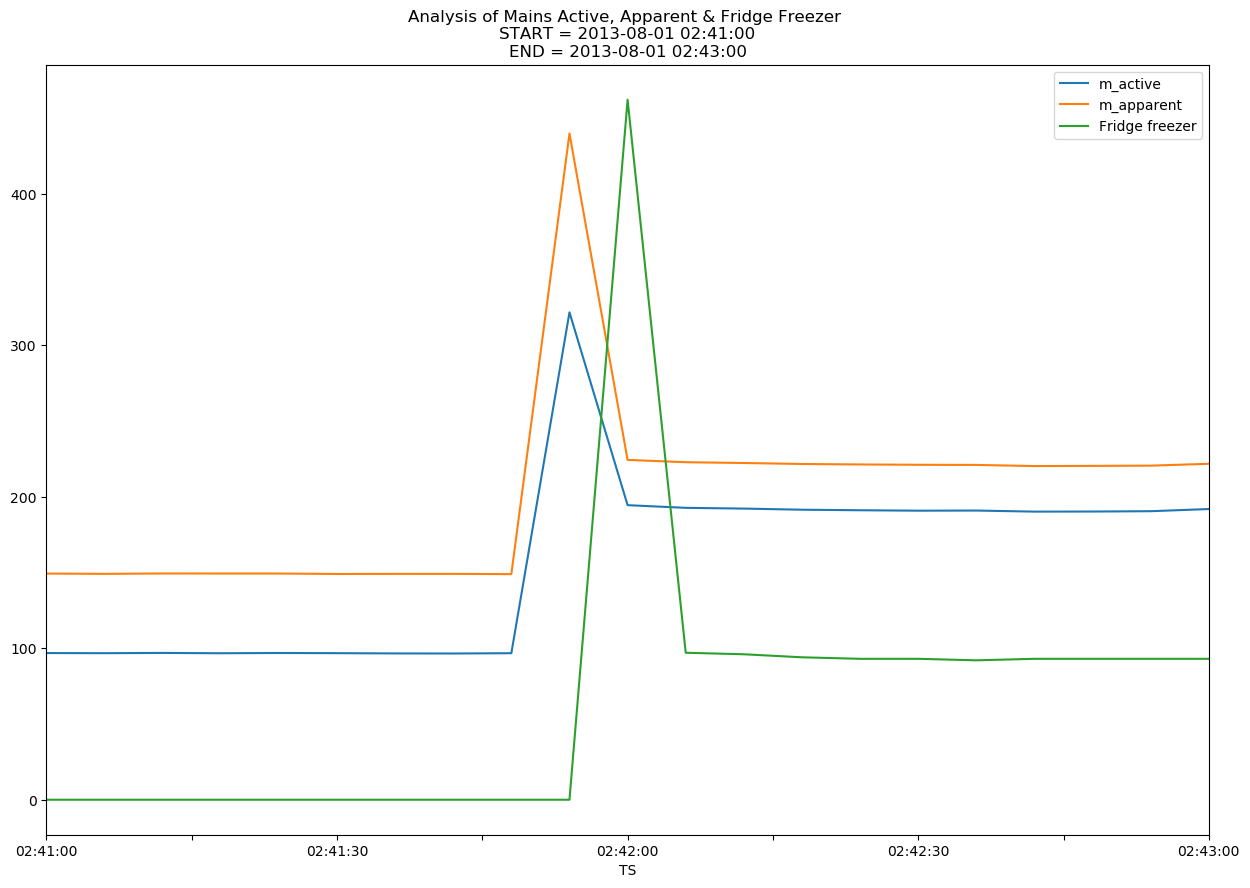

In [44]:
merge_df_slide["TS"] = merge_df_slide.index.strftime('%H:%M:%S')
merge_df_slide = merge_df_slide.set_index('TS')
mytitle = "Analysis of Mains Active, Apparent & Fridge Freezer \n" + "START = " + ts_zoom_start + "\n" + "END = " + ts_zoom_end

merge_df_slide.plot(title=mytitle)

## mains - voltage VS mains - active, apparent and fridge freezer 

In [45]:
# Another method to select column(s) from a dataframe
voltage_df = merge_df.copy()
voltage_df = merge_df[["m_voltage"]]
voltage_df = voltage_df.loc[ts_zoom_start : ts_zoom_end]

print("Shape of dataframe - voltage_df : {}".format((voltage_df.shape)))
voltage_df.head(voltage_df.shape[0])

Shape of dataframe - voltage_df : (21, 1)


,m_voltage
2013-08-01 02:41:00+01:00,243.205002
2013-08-01 02:41:06+01:00,243.330002
2013-08-01 02:41:12+01:00,243.416672
2013-08-01 02:41:18+01:00,243.084991
2013-08-01 02:41:24+01:00,243.276672
2013-08-01 02:41:30+01:00,243.279999
2013-08-01 02:41:36+01:00,243.261658
2013-08-01 02:41:42+01:00,243.054993
2013-08-01 02:41:48+01:00,243.286667
2013-08-01 02:41:54+01:00,243.283325


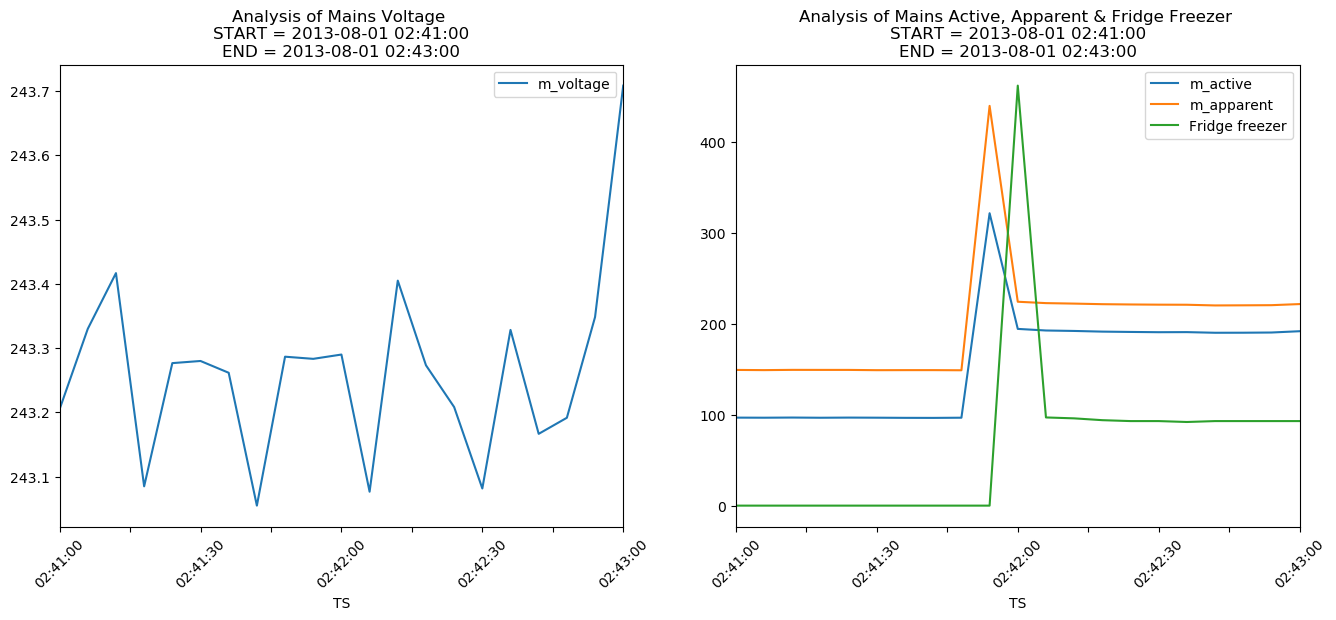

In [46]:
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(16, 6))

voltage_df["TS"] = voltage_df.index.strftime('%H:%M:%S')
voltage_df = voltage_df.set_index('TS')
mytitle_vol = "Analysis of Mains Voltage \n" + "START = " + ts_zoom_start + "\n" + "END = " + ts_zoom_end

voltage_df.plot(title=mytitle_vol,
                rot=45,
                ax = axes[0])

merge_df_slide.plot(title=mytitle,
                    rot=45,
                    ax = axes[1])

# Workout & Findings

After the completion this notebook, prepare a simple presentation slide to express your summary and new discovery information from here.

- Further enhancement of more detail analysis
- Develop in a way that it is reusable